# Mklearn Tutorial on Simulated Dataset

In [4]:
# import standard packages
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline
import importlib
import sklearn
from sklearn import preprocessing
import scipy
import sklearn.datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# import mklearn and multiclass
LIB_PATH = 'mklearn/'
sys.path.append(LIB_PATH)
import mklearn
import multiclass
importlib.reload(mklearn)
importlib.reload(multiclass)

<module 'multiclass' from 'mklearn/multiclass.py'>

In [12]:
# generate simulated data and split into test and train
X, y = sklearn.datasets.make_classification(n_samples=1000, n_features=20, 
                                            n_informative=5, n_classes=5)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train shape: (700, 20)
y_train shape: (700,)
X_test shape: (300, 20)
y_test shape: (300,)


We have 1000 observatins with 20 features, 5 of which are relevant. There are aldo 5 classes in the simulated dataset, and is split 70/30 for train and test.

We first train on portion of the dataset using binary classification.

In [26]:
# get subset of simulated data 
def get_data(X, y, classes):
    # get indicies
    c1, c2 = classes[0], classes[1]
    c1_ind, c2_ind = np.where(y == c1)[0], np.where(y == c2)[0]
    # get data subsets
    X_sub = np.concatenate([X[c1_ind,:], X[c2_ind,:]])
    y_sub = np.concatenate([y[c1_ind], y[c2_ind]])
    # relabel y
    y_sub[y_sub == c2] = -1.0
    y_sub[y_sub == c1] = 1.0
    # standardize X
    Xscaler = preprocessing.StandardScaler().fit(X_sub)
    X_sub = Xscaler.transform(X_sub)
    return X_sub, y_sub

X_sub, y_sub = get_data(X_train, y_train, (0, 1))
X_sub_test, y_sub_test = get_data(X_test, y_test, (0, 1))

final objective: 0.94195
final train error: 0.3069
final validation error: 0.30973


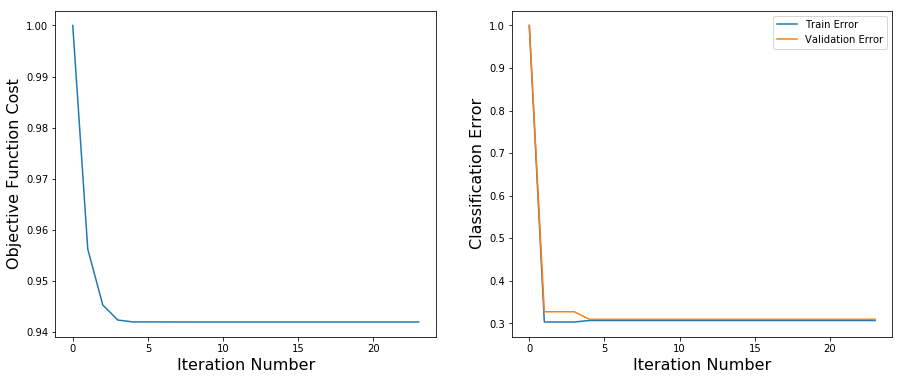

In [28]:
# train binary classification model using myLinearSVC
myLinearSVC_model = mklearn.myLinearSVC(loss='smooth_hinge', tol=1e-6, C=1.0, 
                                        verbose=False, max_iter=1000)
myLinearSVC_model.fit(X_sub, y_sub)
myLinearSVC_model.display_results(X_sub_test, y_sub_test)

Now we train a linear SVM model using mklearn. mklearn does multiclass classification using one-vs-one method. A default regularization penalty value of $1.0$ is used for this demo.

In [31]:
# input parameters
classes = np.arange(5)
penalty = 1.0
max_iter = 1000
n_threads = 10
verbose = False
tol = 1e-6
multi_class = 'ovo'
# fit model
myLinearSVC_model = mklearn.myLinearSVC(loss='smooth_hinge', tol=tol, C=penalty)
myLinearSVC_ovo = multiclass.Multiclass(myLinearSVC_model, classes, multiclass=multi_class,
                                       n_threads=n_threads, Cs=None, k=1) 
myLinearSVC_ovo.fit(X_train, y_train)

ovo multiclass using 1-folds cross-validation
Fitting ovo model for pair (0, 1)
k = 1, no cross-validation case...
fitting with optimal penalty 1.0
Model fit complete. Final objective cost: 1.0
Final training error: 1.0

Fitting ovo model for pair (0, 2)
k = 1, no cross-validation case...
fitting with optimal penalty 1.0
Model fit complete. Final objective cost: 0.8364674089003914
Final training error: 0.19014084507042253

Fitting ovo model for pair (0, 3)
k = 1, no cross-validation case...
fitting with optimal penalty 1.0
Model fit complete. Final objective cost: 0.8449997645225106
Final training error: 0.2229965156794425

Fitting ovo model for pair (0, 4)
k = 1, no cross-validation case...
fitting with optimal penalty 1.0
Model fit complete. Final objective cost: 0.8813162709320728
Final training error: 0.2636986301369863

Fitting ovo model for pair (1, 2)
k = 1, no cross-validation case...
fitting with optimal penalty 1.0
Model fit complete. Final objective cost: 0.8702493487376408


In [32]:
# predict and check accuracy
y_train_pred = multiclass.predict_multiclass(X_train, myLinearSVC_ovo.scalers, 
                                             myLinearSVC_ovo.fitted_betas, classes, 
                                             n_threads, 'ovo', multiclass.predict_binary_class)
y_test_pred = multiclass.predict_multiclass(X_test, myLinearSVC_ovo.scalers, 
                                            myLinearSVC_ovo.fitted_betas, classes, 
                                            n_threads, 'ovo', multiclass.predict_binary_class)
ovo_error_train = multiclass.compute_multi_classification_error(y_train, y_train_pred)
ovo_error_test = multiclass.compute_multi_classification_error(y_test, y_test_pred)
print('OVO training error: {}, OVO test error: {}'.format(round(ovo_error_train, 3), 
                                                          round(ovo_error_test, 3)))

Performing multiclass prediction using 10 threads...
Multiclass prediction complete. Elapsed time: 0.109s
Performing multiclass prediction using 10 threads...
Multiclass prediction complete. Elapsed time: 0.106s
OVO training error: 0.544, OVO test error: 0.563


We see error of $54.4\%$ for training set and $56.3\%$ for the test set. 

For the simulated dataset, let's perform 5-fold cross-validation for the regularization penalty value. 

In [34]:
# input parameters
classes = np.arange(5)
Cs = [0.01, 0.1, 1.0, 10.0, 100.0]
max_iter = 1000
n_threads = 10
verbose = False
tol = 1e-6
multi_class = 'ovo'
# fit model
myLinearSVC_model = mklearn.myLinearSVC(loss='smooth_hinge', tol=tol, C=penalty)
myLinearSVC_ovo = multiclass.Multiclass(myLinearSVC_model, classes, multiclass=multi_class,
                                       n_threads=n_threads, Cs=Cs, k=5) 
myLinearSVC_ovo.fit(X_train, y_train)

ovo multiclass using 5-folds cross-validation
Fitting ovo model for pair (0, 1)
Performing 5-fold cross-validation...
Performing cross-validation...

Regularization penalty value: 0.01
CV Error: 0.683
Regularization penalty value: 0.1
CV Error: 0.686
Regularization penalty value: 1.0
CV Error: 0.676
Regularization penalty value: 10.0
CV Error: 0.676
Regularization penalty value: 100.0
CV Error: 0.676
Best lambda: 1.0
fitting with optimal penalty 1.0
Model fit complete. Final objective cost: 1.0
Final training error: 0.6758620689655173

Fitting ovo model for pair (0, 2)
Performing 5-fold cross-validation...
Performing cross-validation...

Regularization penalty value: 0.01
CV Error: 0.189
Regularization penalty value: 0.1
CV Error: 0.196
Regularization penalty value: 1.0
CV Error: 0.246
Regularization penalty value: 10.0
CV Error: 0.25
Regularization penalty value: 100.0
CV Error: 0.25
Best lambda: 0.01
fitting with optimal penalty 0.01
Model fit complete. Final objective cost: 0.459139

In [35]:
# predict and check accuracy
y_train_pred = multiclass.predict_multiclass(X_train, myLinearSVC_ovo.scalers, 
                                             myLinearSVC_ovo.fitted_betas, classes, 
                                             n_threads, 'ovo', multiclass.predict_binary_class)
y_test_pred = multiclass.predict_multiclass(X_test, myLinearSVC_ovo.scalers, 
                                            myLinearSVC_ovo.fitted_betas, classes, 
                                            n_threads, 'ovo', multiclass.predict_binary_class)
ovo_error_train = multiclass.compute_multi_classification_error(y_train, y_train_pred)
ovo_error_test = multiclass.compute_multi_classification_error(y_test, y_test_pred)
print('OVO training error: {}, OVO test error: {}'.format(round(ovo_error_train, 3), 
                                                          round(ovo_error_test, 3)))

Performing multiclass prediction using 10 threads...
Multiclass prediction complete. Elapsed time: 0.188s
Performing multiclass prediction using 10 threads...
Multiclass prediction complete. Elapsed time: 0.105s
OVO training error: 0.493, OVO test error: 0.547


And we see errors of $49.3\%$ for training set and $54.7\%$ for the test set, improvements over the default penalty of $1.0$.